# LSTM

https://github.com/soms98/Stock-Price-Prediction-Time-Series-LSTM-Model-Keras-Tensorflow/blob/master/HDFC.ipynb
https://www.youtube.com/watch?v=CbTU92pbDKw&t=1312s

https://medium.com/mlearning-ai/multivariate-time-series-forecasting-using-rnn-lstm-8d840f3f9aa7



In [1]:
import pandas as pd
import numpy as np
import yfinance as yf

# Import tensorflow packages
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import EarlyStopping # EarlyStopping during model training
from sklearn.metrics import mean_absolute_error, mean_squared_error # Packages for measuring model performance / errors
from sklearn.model_selection import TimeSeriesSplit

# Displaying data
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

# Preprocessing data
from talib import abstract
from sklearn.preprocessing import RobustScaler, MinMaxScaler 
import math # Mathematical functions 


2023-05-01 19:21:18.823944: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-01 19:21:18.890657: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-01 19:21:18.891811: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-01 19:21:19.949741: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Project variabels

In [2]:
symbol = "EURUSD=X"
interval ='5m'
period = '1mo'

train_size_fraction = 0.70

## Download data

In [3]:
def getHistoryYfinance(symbol, interval, period):

    data = yf.download(  # or pdr.get_data_yahoo(...
    # Yahoo finance symbol
    tickers = symbol,

    # use "period" instead of start/end
    # valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
    # (optional, default is '1mo')
    period = period,

    # fetch data by interval (including intraday if period < 60 days)
    # valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
    # (optional, default is '1d')
    interval = interval,

    # group by ticker (to access via data['SPY'])
    # (optional, default is 'column')
    group_by = 'ticker',

    # adjust all OHLC automatically
    # (optional, default is False)
    auto_adjust = False,

    # download pre/post regular market hours data
    # (optional, default is False)
    prepost = False,

    # use threads for mass downloading? (True/False/Integer)
    # (optional, default is True)
    threads = True,

    # proxy URL scheme use use when downloading?
    # (optional, default is None)
    proxy = None
    )
    
    data["returns"] = data['Close'] / data['Close'].shift(1)
    data.drop(['Adj Close', 'Volume'], axis='columns', inplace=True)
    data.dropna(inplace=True)
    
    return data  

In [4]:
Data_Raw = getHistoryYfinance(symbol, interval, period)
Data_Raw.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,returns
Datetime,,,,,
2023-04-03 00:05:00+01:00,1.082485,1.082837,1.082251,1.082251,0.999783
2023-04-03 00:10:00+01:00,1.082134,1.082251,1.081783,1.082251,1.000000
2023-04-03 00:15:00+01:00,1.081900,1.082134,1.081900,1.082134,0.999892
2023-04-03 00:20:00+01:00,1.082134,1.082134,1.081432,1.081432,0.999351
2023-04-03 00:25:00+01:00,1.081666,1.082134,1.081549,1.081549,1.000108


## Display data

Text(0.5, 1.0, 'EURUSD=X Close Price')

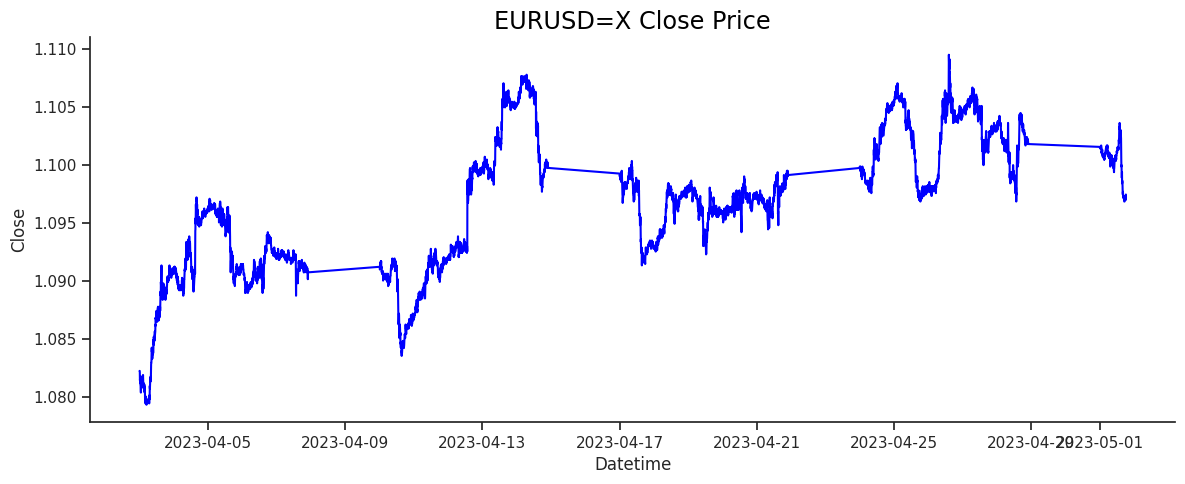

In [5]:
plt.figure(figsize=(14,5))
sns.set_style("ticks")
sns.lineplot(data=Data_Raw,x="Datetime",y='Close',color='blue')
sns.despine()
plt.title(symbol + ' Close Price',size='x-large',color='black')

## Create features

In [6]:
def prepare_features(data):
    ''' Prepares the feature columns for training set and test set.
    '''
    feature_columns = []
    lags = 5
    
    for lag in range(1, lags + 1):
        col = "lag{}".format(lag)
        data[col] = data["returns"].shift(lag)
        feature_columns.append(col)
        
    data['Ask_Dir'] = np.where(data['Close'].shift(-1) > data.Close, 1, 0)
    feature_columns.append('Ask_Dir')

    data['SMA'] = abstract.SMA(data['Close'], timeperiod=12)
    feature_columns.append('SMA')
    data['SMA_Dir'] = np.where(data['SMA'].shift(-1) > data.SMA, 1, 0)
    feature_columns.append('SMA_Dir')

    data['RSI'] = abstract.RSI(data['Close'], timeperiod=12)
    feature_columns.append('RSI')
    data['RSI_Dir'] = np.where(data['RSI'].shift(-1) > data.RSI, 1, 0)
    feature_columns.append('RSI_Dir')
    
    data['fastk'], data['fastd'] = abstract.STOCHRSI(data["Close"], timeperiod=14, fastk_period=5, fastd_period=3, fastd_matype=0)
    feature_columns.append('fastk')
    feature_columns.append('fastd')
    data['fastk_Dir'] = np.where(data['fastk'].shift(-1) > data.fastk, 1, 0)
    feature_columns.append('fastk_Dir')
    data['fastd_Dir'] = np.where(data['fastd'].shift(-1) > data.fastd, 1, 0)    
    feature_columns.append('fastd_Dir')
        
    data.dropna(inplace=True)
    
    return data, feature_columns

Data_Processed, feature_columns = prepare_features(Data_Raw)

In [7]:
Data_Processed.head()

,Open,High,Low,Close,returns,lag1,lag2,lag3,lag4,lag5,Ask_Dir,SMA,SMA_Dir,RSI,RSI_Dir,fastk,fastd,fastk_Dir,fastd_Dir
Datetime,,,,,,,,,,,,,,,,,,,
2023-04-03 01:45:00+01:00,1.081432,1.081432,1.081198,1.081198,0.999784,1.000108,0.999892,1.000433,0.999784,1.000433,1,1.081052,1,42.170996,1,63.930234,84.620790,1,1
2023-04-03 01:50:00+01:00,1.081315,1.081549,1.081315,1.081549,1.000324,0.999784,1.000108,0.999892,1.000433,0.999784,1,1.081091,1,48.108063,1,100.000000,87.976745,0,0
2023-04-03 01:55:00+01:00,1.081315,1.081783,1.081315,1.081783,1.000216,1.000324,0.999784,1.000108,0.999892,1.000433,0,1.081188,1,51.715143,0,100.000000,87.976745,0,1
2023-04-03 02:00:00+01:00,1.081549,1.081549,1.081549,1.081549,0.999784,1.000216,1.000324,0.999784,1.000108,0.999892,0,1.081286,1,48.069969,0,64.114926,88.038309,0,0
2023-04-03 02:05:00+01:00,1.081549,1.081666,1.081432,1.081432,0.999892,0.999784,1.000216,1.000324,0.999784,1.000108,0,1.081305,1,46.289388,0,46.508851,70.207926,0,0


In [8]:
Data_Processed.tail()

,Open,High,Low,Close,returns,lag1,lag2,lag3,lag4,lag5,Ask_Dir,SMA,SMA_Dir,RSI,RSI_Dir,fastk,fastd,fastk_Dir,fastd_Dir
Datetime,,,,,,,,,,,,,,,,,,,
2023-05-01 18:00:00+01:00,1.097093,1.097213,1.097093,1.097213,1.000110,0.999781,1.000110,1.000110,0.999890,1.000110,0,1.097063,0,41.143483,0,90.029556,77.095877,0,0
2023-05-01 18:05:00+01:00,1.097213,1.097213,1.096972,1.096972,0.999781,1.000110,0.999781,1.000110,1.000110,0.999890,1,1.097063,1,35.989624,1,0.000000,43.762544,1,1
2023-05-01 18:10:00+01:00,1.096972,1.097213,1.096972,1.097213,1.000219,0.999781,1.000110,0.999781,1.000110,1.000110,1,1.097093,1,43.685222,1,100.000000,63.343185,0,1
2023-05-01 18:15:00+01:00,1.097333,1.097454,1.097333,1.097454,1.000220,1.000219,0.999781,1.000110,0.999781,1.000110,0,1.097143,1,50.220460,0,100.000000,66.666667,0,1
2023-05-01 18:20:00+01:00,1.097454,1.097454,1.097454,1.097454,1.000000,1.000220,1.000219,0.999781,1.000110,0.999781,0,1.097193,0,50.220460,0,100.000000,100.000000,0,0


In [9]:
Data_Processed.describe()

,Open,High,Low,Close,returns,lag1,lag2,lag3,lag4,lag5,Ask_Dir,SMA,SMA_Dir,RSI,RSI_Dir,fastk,fastd,fastk_Dir,fastd_Dir
count,5887.000000,5887.000000,5887.000000,5887.000000,5887.000000,5887.000000,5887.000000,5887.000000,5887.000000,5887.000000,5887.000000,5887.000000,5887.000000,5887.000000,5887.000000,5887.000000,5.887000e+03,5887.000000,5887.000000
mean,1.096668,1.096846,1.096527,1.096672,1.000003,1.000003,1.000003,1.000003,1.000003,1.000003,0.404790,1.096657,0.487515,50.718530,0.446747,48.872698,4.887213e+01,0.375403,0.429760
std,0.005723,0.005721,0.005718,0.005721,0.000304,0.000304,0.000304,0.000304,0.000304,0.000304,0.490893,0.005725,0.499887,10.992399,0.497198,41.670266,3.113673e+01,0.484268,0.495084
min,1.079214,1.079331,1.079214,1.079331,0.997355,0.997355,0.997355,0.997355,0.997355,0.997355,0.000000,1.079593,0.000000,17.276840,0.000000,0.000000,-1.278977e-13,0.000000,0.000000
25%,1.092061,1.092180,1.091941,1.092061,0.999890,0.999890,0.999890,0.999890,0.999890,0.999890,0.000000,1.092041,0.000000,43.696720,0.000000,0.000000,2.294641e+01,0.000000,0.000000
50%,1.097093,1.097213,1.096972,1.097093,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.097063,0.000000,50.789544,0.000000,45.872439,4.779740e+01,0.000000,0.000000
75%,1.100837,1.100958,1.100594,1.100837,1.000111,1.000111,1.000111,1.000111,1.000111,1.000111,1.000000,1.100847,1.000000,58.048439,1.000000,100.000000,7.421644e+01,1.000000,1.000000
max,1.109139,1.109509,1.109139,1.109509,1.005603,1.005603,1.005603,1.005603,1.005603,1.005603,1.000000,1.108433,1.000000,88.176754,1.000000,100.000000,1.000000e+02,1.000000,1.000000


In [10]:
Data_Processed.dtypes

Open         float64
High         float64
Low          float64
Close        float64
returns      float64
lag1         float64
lag2         float64
lag3         float64
lag4         float64
lag5         float64
Ask_Dir        int64
SMA          float64
SMA_Dir        int64
RSI          float64
RSI_Dir        int64
fastk        float64
fastd        float64
fastk_Dir      int64
fastd_Dir      int64
dtype: object

In [11]:
print(feature_columns)

['lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'Ask_Dir', 'SMA', 'SMA_Dir', 'RSI', 'RSI_Dir', 'fastk', 'fastd', 'fastk_Dir', 'fastd_Dir']


In [12]:
df = Data_Processed.sort_values(by=['Datetime']).copy()
data = pd.DataFrame(df)
data_filtered = data[feature_columns]

In [13]:
# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
data_filtered_ext['Prediction'] = df['returns']

## Split Data

In [14]:

min_date = data_filtered_ext.index.min()
max_date = data_filtered_ext.index.max()
print("Min:", min_date, "Max:", max_date)



Min: 2023-04-03 01:45:00+01:00 Max: 2023-05-01 18:20:00+01:00


In [15]:

train_percent = .75
time_between = max_date - min_date
train_cutoff = min_date + train_percent*time_between
train_cutoff


Timestamp('2023-04-24 14:11:15+0100', tz='Europe/London')

In [16]:

df_train = data_filtered_ext[data_filtered_ext.index <= train_cutoff]
df_test = data_filtered_ext[data_filtered_ext.index > train_cutoff]
print("Train:", df_train.index.min(), df_train.index.max())
print("Test:", df_test.index.min(), df_test.index.max())


Train: 2023-04-03 01:45:00+01:00 2023-04-24 14:10:00+01:00
Test: 2023-04-24 14:15:00+01:00 2023-05-01 18:20:00+01:00


## Scaling data
### Convert to numpy array

In [17]:
# Get the number of rows in the data
def convert_to_np(pd_data):
    nrows = pd_data.shape[0]

    # Convert the data to numpy values
    np_data_unscaled = np.array(pd_data)
    np_data = np.reshape(np_data_unscaled, (nrows, -1))
    print(np_data.shape)
    
    return np_data


In [18]:
np_x_train = convert_to_np(df_train[feature_columns])
np_x_test = convert_to_np(df_test[feature_columns])
np_y_train = convert_to_np(df_train['Prediction'])
np_y_test = convert_to_np(df_test['Prediction'])

(4415, 14)
(1472, 14)
(4415, 1)
(1472, 1)


### Scale data

In [19]:
# Transform the data by scaling each feature to a range between 0 and 1
def scale_np(np_data):
    obj_scaler = MinMaxScaler()
    np_data_scaled = obj_scaler.fit_transform(np_data)
    
    return np_data_scaled, obj_scaler


In [20]:
np_x_train_scale, scaler = scale_np(np_x_train)
np_x_test_scale, scaler_data = scale_np(np_x_test)
np_y_train_scale, scaler = scale_np(np_y_train)
np_y_test_scale, scaler_pred = scale_np(np_y_test)

## Split data into training and test

In [21]:
index_target = df.columns.get_loc("returns")

In [22]:
# Prediction Index
sequence_length = 5
# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_x_dataset(sequence_length, data):
    x = []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
    
    # Convert the x to numpy array
    x = np.array(x)

    return x

def partition_y_dataset(sequence_length, data):
    y = []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        y.append(data[i, 0]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the y to numpy array
    y = np.array(y)
    return y

# Generate training data and test data
x_train = partition_x_dataset(sequence_length, np_x_train_scale)
x_test = partition_x_dataset(sequence_length, np_x_test_scale)
y_train = partition_y_dataset(sequence_length, np_y_train_scale)
y_test = partition_y_dataset(sequence_length, np_y_test_scale)


In [23]:
len(x_train)

4410

In [24]:
# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(4410, 5, 14) (4410,)
(1467, 5, 14) (1467,)


In [25]:
# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_target])
print(y_train[0])

0.285131643926789
0.31168650017625055


In [39]:
# Configure the neural network model
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(LSTM(n_neurons, return_sequences=True, activation='relu'))
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

70 5 14


2023-05-01 19:58:50.086467: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-01 19:58:50.089318: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-01 19:58:50.091938: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [40]:
# Training the model
#epochs = 50
epochs = 200
batch_size = 16
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test)
                   )

Epoch 1/200


2023-05-01 19:58:55.897751: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-01 19:58:55.901906: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-01 19:58:55.905398: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

276/276 [==============================] - ETA: 0s - loss: 0.0027

2023-05-01 19:59:05.678982: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-01 19:59:05.681868: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-01 19:59:05.683900: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

276/276 [==============================] - 12s 19ms/step - loss: 0.0027 - val_loss: 0.0350
Epoch 2/200
276/276 [==============================] - 4s 14ms/step - loss: 0.0013 - val_loss: 0.0230
Epoch 3/200
276/276 [==============================] - 4s 14ms/step - loss: 8.6030e-04 - val_loss: 0.0252
Epoch 4/200
276/276 [==============================] - 3s 12ms/step - loss: 7.1092e-04 - val_loss: 0.0285
Epoch 5/200
276/276 [==============================] - 3s 12ms/step - loss: 7.1242e-04 - val_loss: 0.0303
Epoch 6/200
276/276 [==============================] - 3s 12ms/step - loss: 6.8829e-04 - val_loss: 0.0333
Epoch 7/200
276/276 [==============================] - 3s 12ms/step - loss: 6.7969e-04 - val_loss: 0.0303
Epoch 8/200
276/276 [==============================] - 3s 12ms/step - loss: 6.9623e-04 - val_loss: 0.0330
Epoch 9/200
276/276 [==============================] - 3s 12ms/step - loss: 6.6860e-04 - val_loss: 0.0356
Epoch 10/200
276/276 [==============================] - 3s 12ms/s

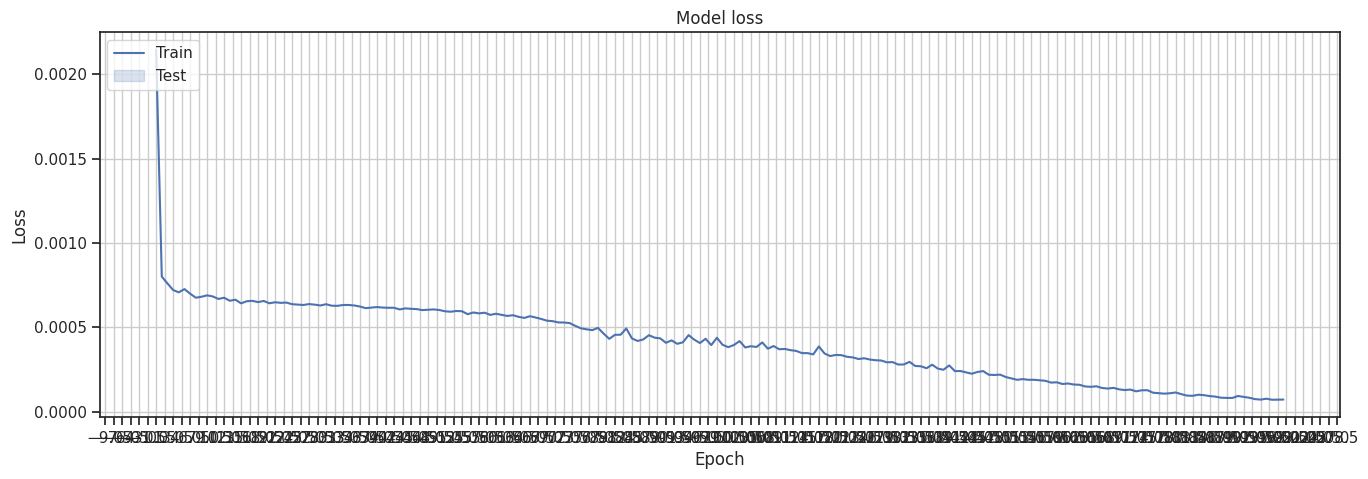

In [28]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(16, 5), sharex=True)
sns.lineplot(data=history.history["loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

# Get the predicted values

In [29]:

y_pred_scaled = model.predict(x_test)

2023-05-01 19:30:35.775487: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-01 19:30:35.778271: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-01 19:30:35.780919: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

46/46 [==============================] - 1s 3ms/step


# Unscale the predicted values

In [30]:
# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')

Median Absolute Error (MAE): 0.0
Mean Absolute Percentage Error (MAPE): 0.1 %
Median Absolute Percentage Error (MDAPE): 0.1 %


In [31]:
df_result = pd.DataFrame(y_test)

df_result['pred'] = y_test_unscaled.tolist()

In [32]:
df_result

,0,pred
0,0.560749,[1.0003306419268028]
1,0.477675,[0.9998897864008532]
2,0.539985,[1.0002204514950461]
3,0.581569,[1.000441130253792]
4,0.498443,[1.0]
...,...,...
1462,0.519103,[1.0001096371964997]
1463,0.457108,[0.9997806409976434]
1464,0.539788,[1.000219407131286]
1465,0.539820,[1.0002195762970592]


In [33]:
predictions = model.predict(x_test)
predictions = scaler_pred.inverse_transform(predictions)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse


46/46 [==============================] - 0s 3ms/step


0.5010639487320598

/home/mik/anaconda3/envs/tensor/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


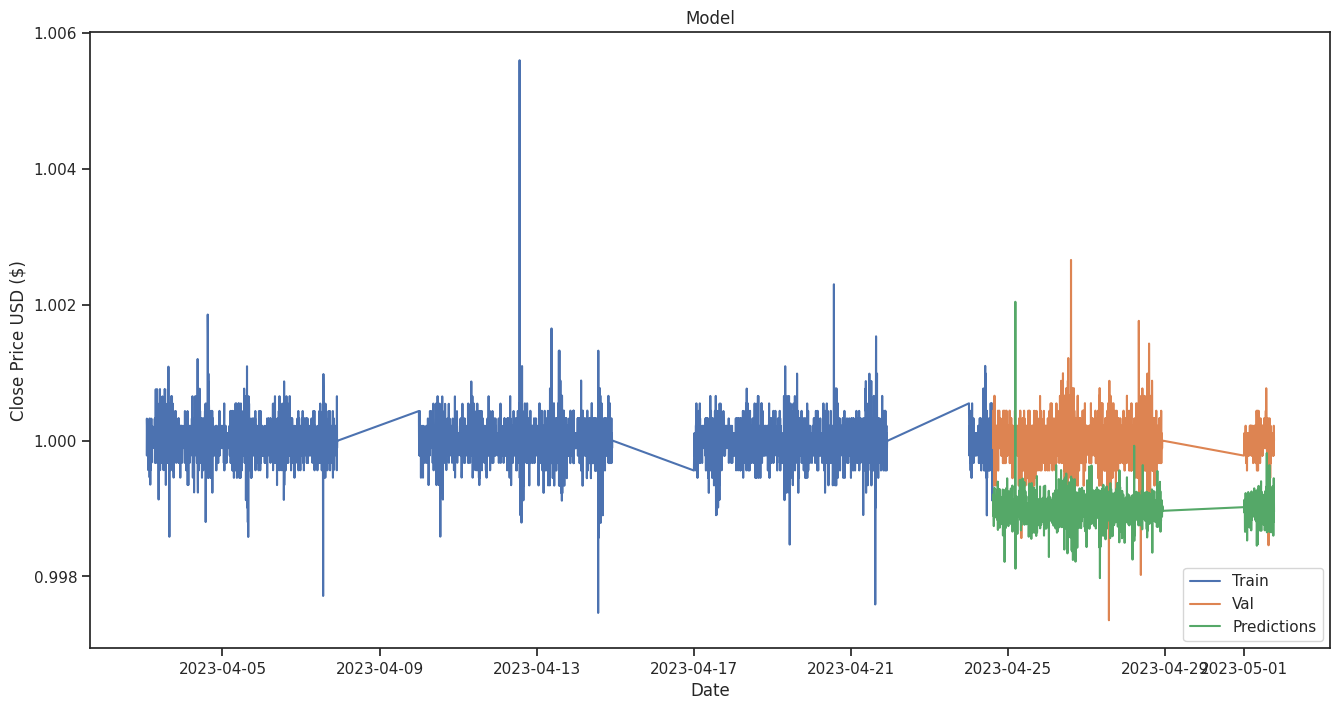

In [38]:
data = Data_Raw.filter(['returns'])
train = data[:4420]
validation = data[4420:]
validation['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train)
plt.plot(validation[['returns', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [ ]:
y_test.shape

(1302,)

In [ ]:
y_train.shape

(5204,)

In [ ]:
len(x_train)

4878